In [1]:
# The workflow for analyzing the routes begins with coordinate points used as origin locations.
import pandas as pd

df = pd.DataFrame({
    "city_name": ["Umeå", "Dresden", "Barcelona"],
    "region": ["europe", "europe", "europe"],
    "country": ["Sweden", "Germany", "Spain"],
})

# To sample nodes from the cities we call use a method from sample_nodes.py
import node_sampling

df = node_sampling.get_random_nodes_for_all_cities(df,min_distance_km=1,sample_size=5)


display(df)

import os # for file operations

if not os.path.exists("example"):
    os.makedirs("example")
df.to_csv("example/city_samples.csv",index=False)


Random nodes for Umeå that are at least 1 km apart: [1062383795, 9104245752, 158590949, 148867317, 4040875938]
Random nodes for Umeå: [1062383795, 9104245752, 158590949, 148867317, 4040875938]
Node: 1062383795
Random node coordinates for Umeå: 63.7999704, 20.3035246
Node: 9104245752
Random node coordinates for Umeå: 63.8464829, 20.146941
Node: 158590949
Random node coordinates for Umeå: 63.8383474, 20.1787082
Node: 148867317
Random node coordinates for Umeå: 63.809464, 20.336842
Node: 4040875938
Random node coordinates for Umeå: 63.8102884, 20.2522875
Random nodes for Dresden that are at least 1 km apart: [9518919174, 29835175, 248219395, 264223496, 243598019]
Random nodes for Dresden: [9518919174, 29835175, 248219395, 264223496, 243598019]
Node: 9518919174
Random node coordinates for Dresden: 51.0194894, 13.7713282
Node: 29835175
Random node coordinates for Dresden: 51.0276707, 13.734063
Node: 248219395
Random node coordinates for Dresden: 51.0361101, 13.8103849
Node: 264223496
Random

,city_name,country,region,network_type,node_id,node_latlon
0,Umeå,Sweden,europe,drive,1062383795,"(63.7999704, 20.3035246)"
1,Umeå,Sweden,europe,drive,9104245752,"(63.8464829, 20.146941)"
2,Umeå,Sweden,europe,drive,158590949,"(63.8383474, 20.1787082)"
3,Umeå,Sweden,europe,drive,148867317,"(63.809464, 20.336842)"
4,Umeå,Sweden,europe,drive,4040875938,"(63.8102884, 20.2522875)"
5,Dresden,Germany,europe,drive,9518919174,"(51.0194894, 13.7713282)"
6,Dresden,Germany,europe,drive,29835175,"(51.0276707, 13.734063)"
7,Dresden,Germany,europe,drive,248219395,"(51.0361101, 13.8103849)"
8,Dresden,Germany,europe,drive,264223496,"(51.0462596, 13.7548715)"
9,Dresden,Germany,europe,drive,243598019,"(50.9963405, 13.8659207)"


Creating origin graph for Umeå node id 1062383795
Saving graph to example/local_origin_graphs\Umeå_1062383795.graphml


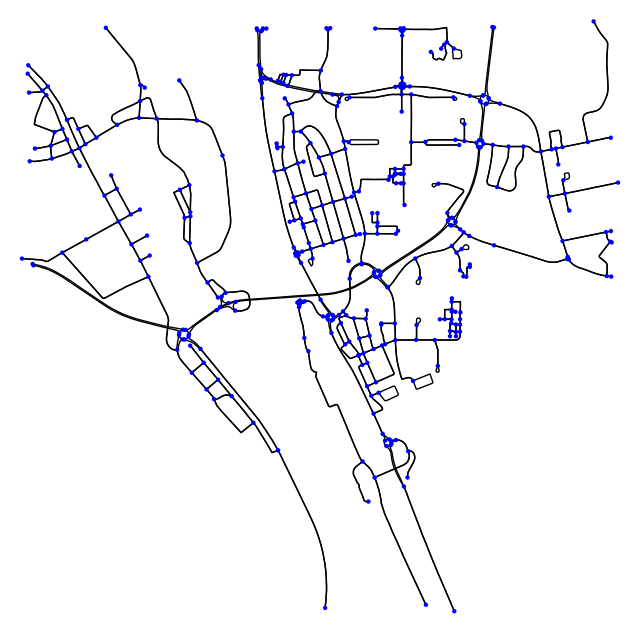

Creating origin graph for Umeå node id 9104245752
Saving graph to example/local_origin_graphs\Umeå_9104245752.graphml


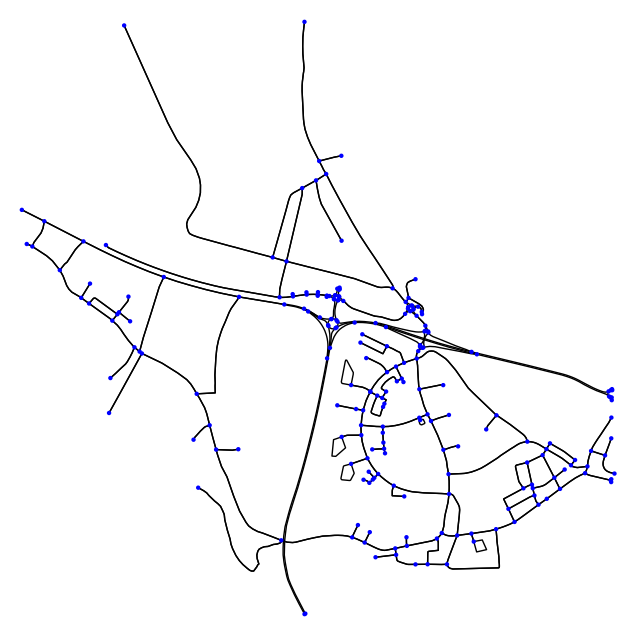

Creating origin graph for Umeå node id 158590949
Saving graph to example/local_origin_graphs\Umeå_158590949.graphml


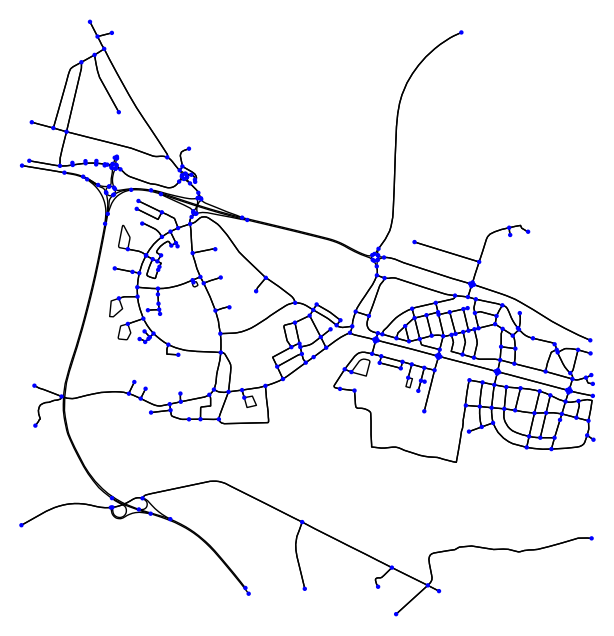

Creating origin graph for Umeå node id 148867317
Saving graph to example/local_origin_graphs\Umeå_148867317.graphml


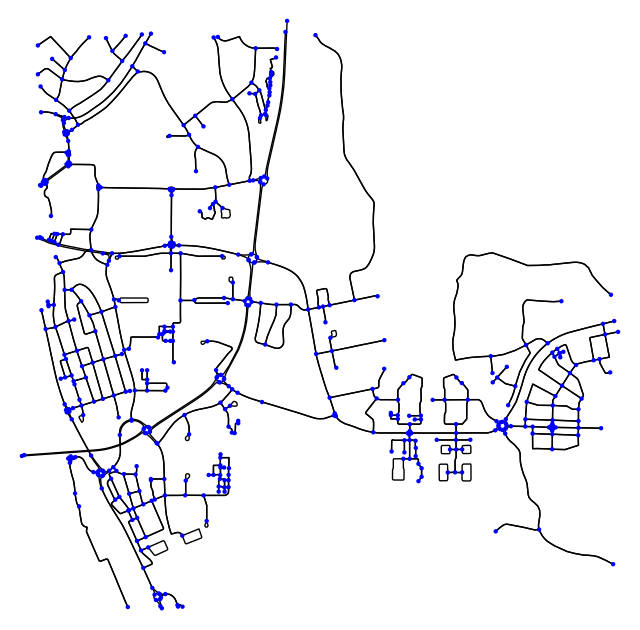

Creating origin graph for Umeå node id 4040875938
Saving graph to example/local_origin_graphs\Umeå_4040875938.graphml


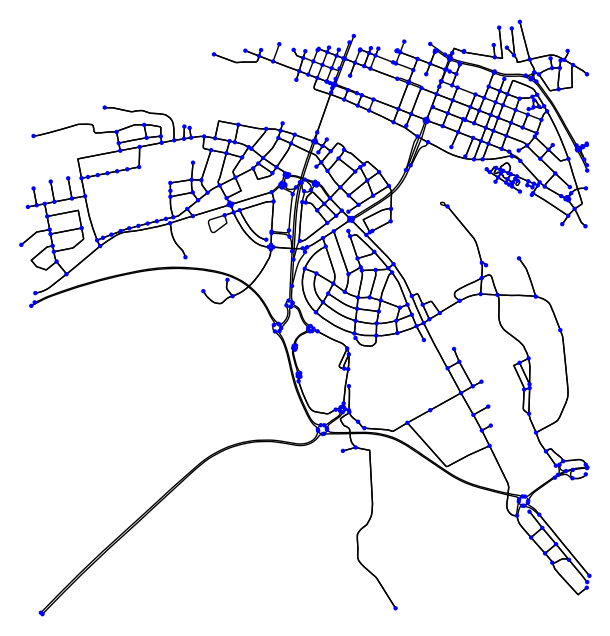

Creating origin graph for Dresden node id 9518919174
Saving graph to example/local_origin_graphs\Dresden_9518919174.graphml


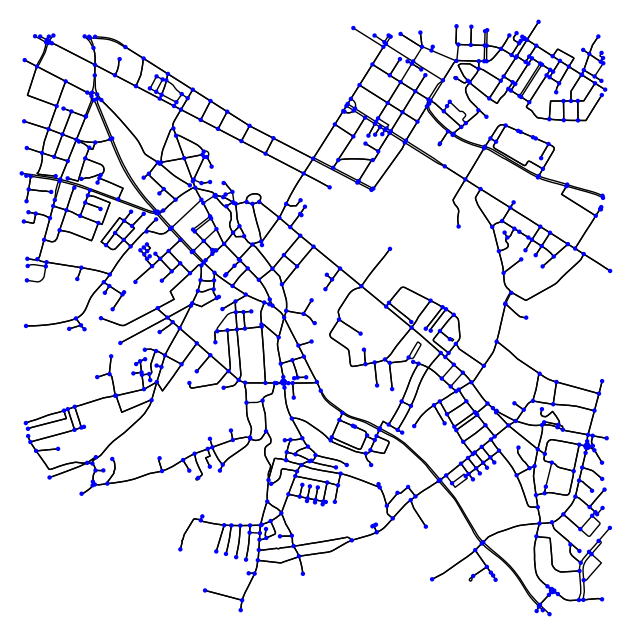

Creating origin graph for Dresden node id 29835175
Saving graph to example/local_origin_graphs\Dresden_29835175.graphml


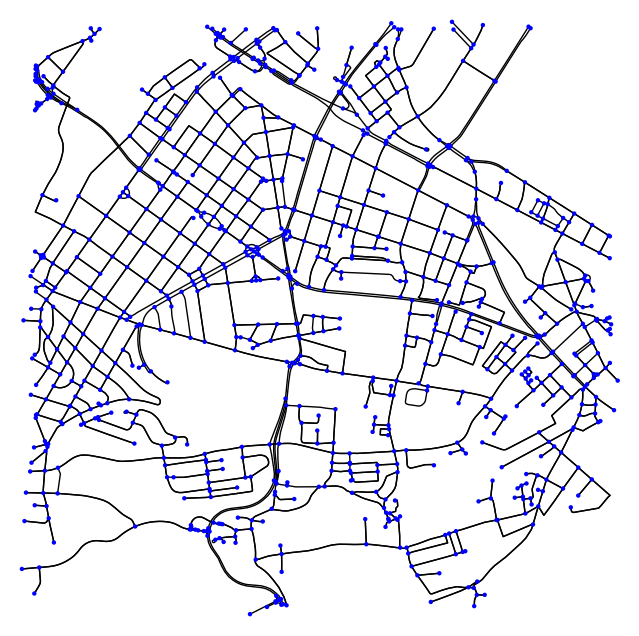

Creating origin graph for Dresden node id 248219395
Saving graph to example/local_origin_graphs\Dresden_248219395.graphml


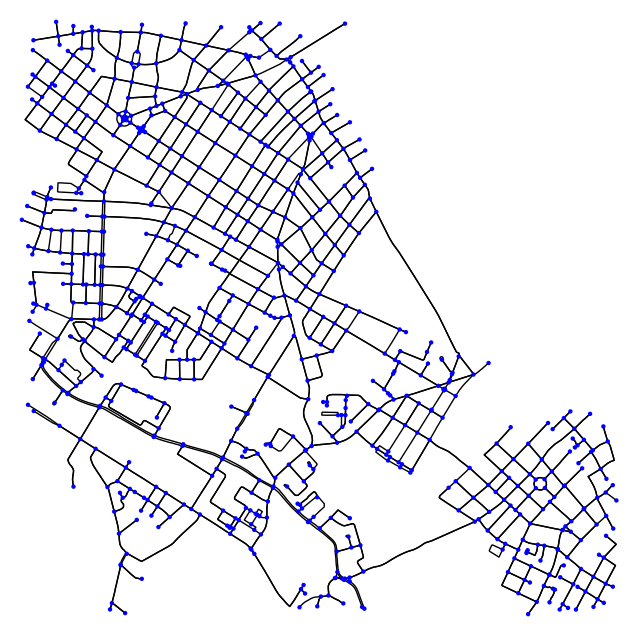

Creating origin graph for Dresden node id 264223496
Saving graph to example/local_origin_graphs\Dresden_264223496.graphml


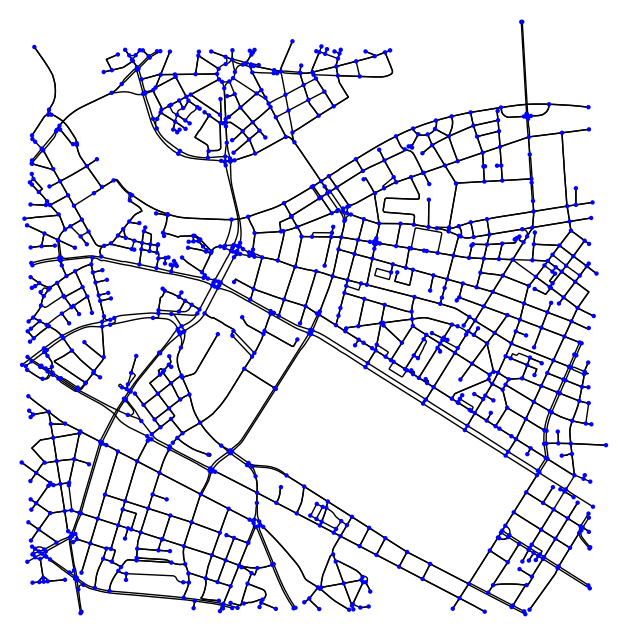

Creating origin graph for Dresden node id 243598019
Saving graph to example/local_origin_graphs\Dresden_243598019.graphml


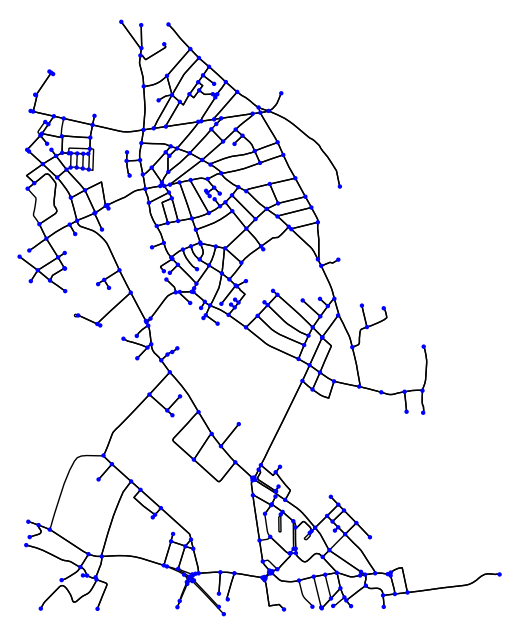

Creating origin graph for Barcelona node id 567453739
Saving graph to example/local_origin_graphs\Barcelona_567453739.graphml


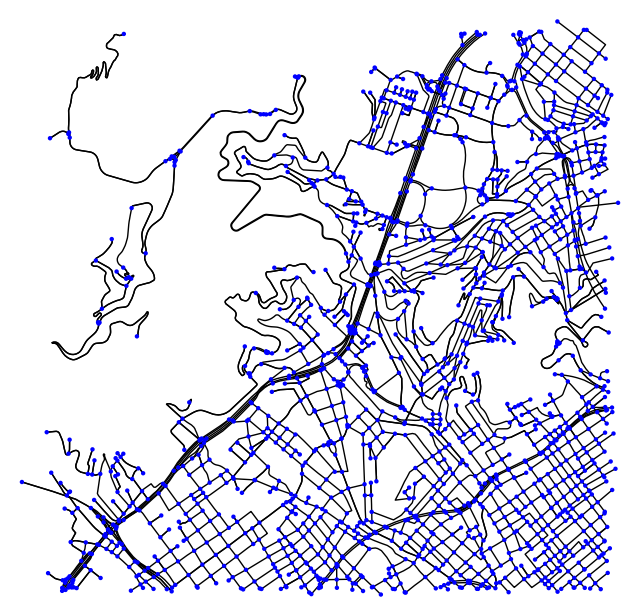

Creating origin graph for Barcelona node id 522578984
Saving graph to example/local_origin_graphs\Barcelona_522578984.graphml


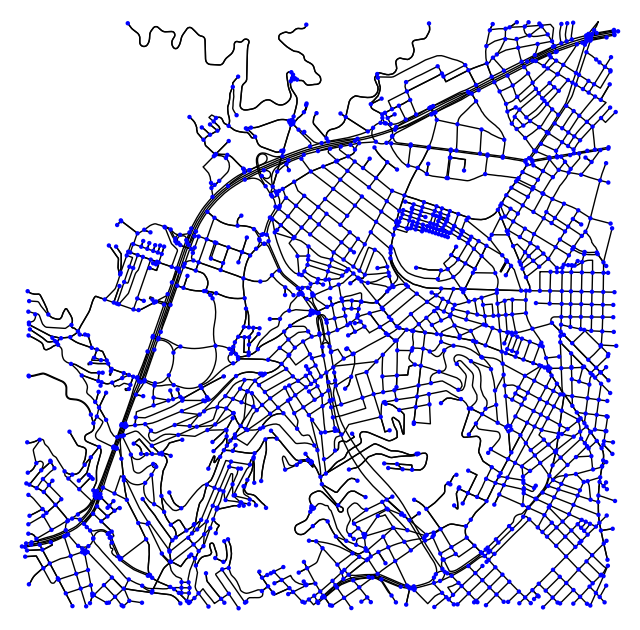

Creating origin graph for Barcelona node id 30227229
Saving graph to example/local_origin_graphs\Barcelona_30227229.graphml


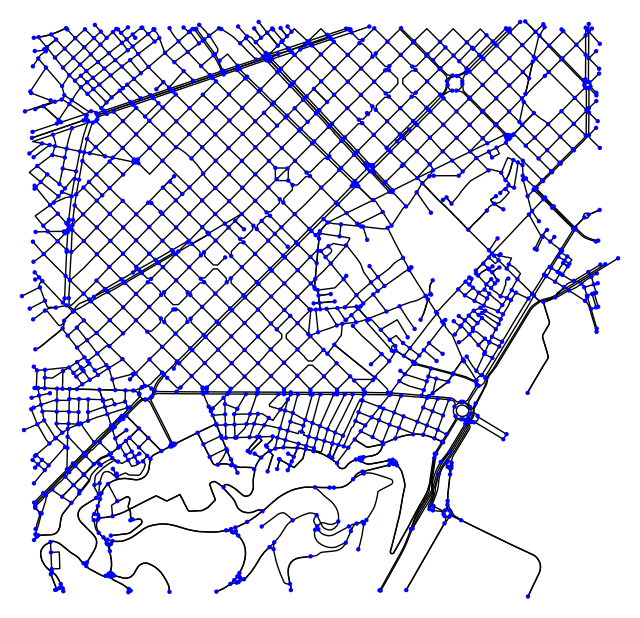

Creating origin graph for Barcelona node id 30332655
Saving graph to example/local_origin_graphs\Barcelona_30332655.graphml


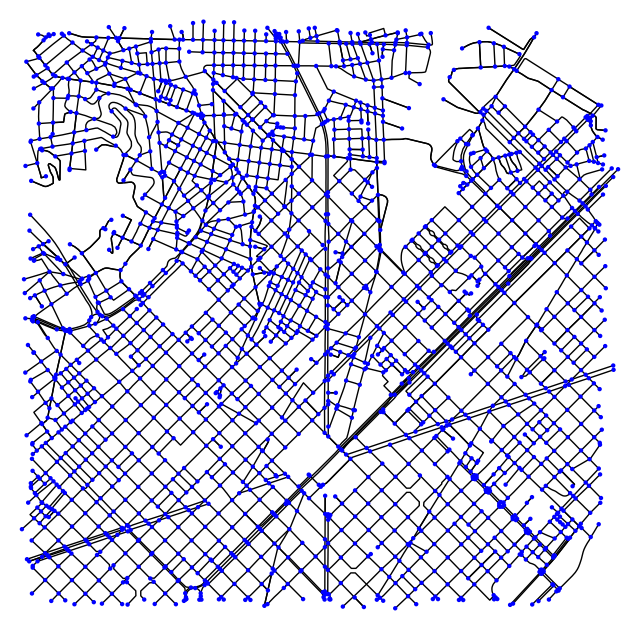

Creating origin graph for Barcelona node id 568847323
Saving graph to example/local_origin_graphs\Barcelona_568847323.graphml


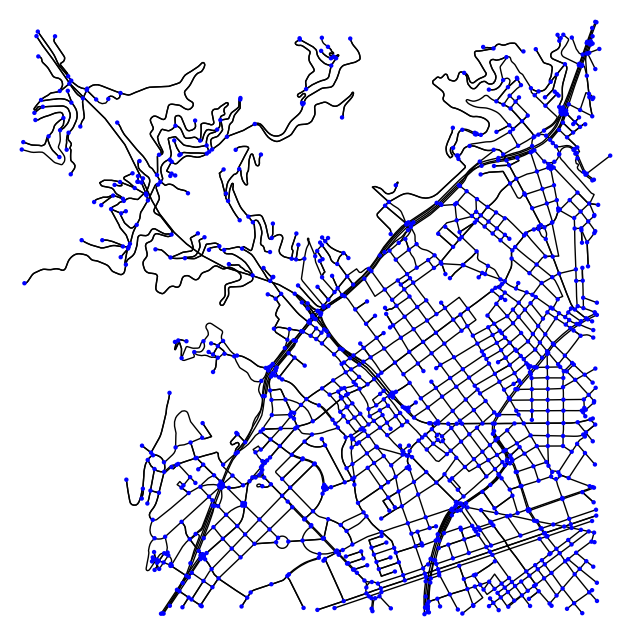

In [2]:
from origin_graph import origin_graph # for creating the origin graph object
import os # for file operations
import ast # for parsing string to tuple
import pandas as pd # for reading the csv file
import osmnx as ox # for plotting the graph
"""
The origin graph object requires the following parameters for instantiation:
# Required parameters:
- origin_point: The coordinate point of the city as a tuple (latitude, longitude)
- distance_from_point: The distance from the origin point in meters to the sides of a bounding box.
- city_name: The name of the city
- network_type: The type of network to use. The default is 'drive'.

# The following parameters are optional:
- remove_parallel: A boolean to remove parallel edges in the graph. The default is False.
- simplify: A boolean to simplify the graph. The default is False.
- edge_attr_diff: The attribute to differentiate edges in the graph when simplifying the graph. The default is None.

# Downloading a graph and weighing it can take some time. To speed up the process, you can load a graph from a file.
- save_graphml: The path to save the graphml file.
- load_graphml: The path to a graphml file to load.
"""

folder = "example/local_origin_graphs"

if not os.path.exists(folder):
    os.makedirs(folder)

df = pd.read_csv("example/city_samples.csv")

df['graph_path'] = None

for index, row in df.iterrows():
    print(f"Creating origin graph for {row['city_name']} node id {row['node_id']}")
    latlon_point = ast.literal_eval(row['node_latlon'])
    og = origin_graph(origin_point=latlon_point, distance_from_point=2000,
                city_name=row["city_name"], network_type='drive', remove_parallel=True, simplify=True)
    
    graph_path = os.path.join(folder, f"{row['city_name']}_{row['node_id']}.graphml")
    print(f"Saving graph to {graph_path}")
    og.save_graph(graph_path)

    # plot the origin graph to see if something is obviously wrong
    ox.plot_graph(og.graph, node_color='blue', node_size=10, edge_linewidth=1, edge_color='black', bgcolor='white')

    # Update the corresponding column in the dataframe
    df.at[index, f'graph_path'] = graph_path

df.to_csv("example/city_samples.csv",index=False)

In [3]:
# The next step is to add weights to the edges of the graph.

from origin_graph import origin_graph # for creating the origin graph object
import os # for file operations
import ast # for parsing string to tuple
import pandas as pd # for reading the csv file

folder = "example/local_origin_graphs"
df = pd.read_csv("example/city_samples.csv")

for index, row in df.iterrows():
    print(f"Adding weights to graph for {row['city_name']} node id {row['node_id']}")
    og = origin_graph.from_graphml(graphml_path=row['graph_path'])

    # Adding the decision complexity weights may take some time.
    og.add_weights('decision_complexity')
    og.add_weights('deviation_from_prototypical')
    og.add_weights('node_degree')
    og.add_weights('instruction_equivalent')

    # We can print the edge weights to see which have been added.
    
    # Save the graph with weights
    og.save_graph(row['graph_path'])

Adding weights to graph for Umeå node id 1062383795
0 edges left
Adding weights to graph for Umeå node id 9104245752
0 edges left
Adding weights to graph for Umeå node id 158590949
0 edges left
Adding weights to graph for Umeå node id 148867317
1000 edges left
0 edges left
Adding weights to graph for Umeå node id 4040875938
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 9518919174
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 29835175
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 248219395
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 264223496
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Dresden node id 243598019
1000 edges left
0 edges left
Adding weights to graph for Barcelona node id 567453739
2000 edges left
1000 edges left
0 edges left
Adding weights to graph for Barcelona node id 522578984
3000 edge

In [4]:
from origin_graph import origin_graph # for creating the origin graph object
import pandas as pd # for reading the csv file

folder = "example/local_origin_graphs"
df = pd.read_csv("example/city_samples.csv")

origins_od_pair_data = []
for index, row in df.iterrows():
    print(f"Creating od-pairs for {row['city_name']} node id {row['node_id']}")
    og = origin_graph.from_graphml(graphml_path=row['graph_path'])

    """
    Parameters:
    - min_distance: The minimum distance in meters between the origin and destination points in great circle distance.
    - max distance: The maximum distance in meters between the origin and destination points in great circle distance.
    - sample_size: The number of origin-destination pairs to sample.

    Return: a dataframe with each row corresponding to an origin-destination pair.
    """
    og.create_od_pairs(min_radius=1000, max_radius=1500, sample_size=144)
    od_pair_data = og.get_od_pair_data()
    origins_od_pair_data.append(od_pair_data)

origin_od_pairs = pd.concat(origins_od_pair_data)
print(f"Number of origin-destination pairs: {len(origin_od_pairs)} in the dataset.")
print(origin_od_pairs.head())
origin_od_pairs.to_json("example/origin_od_pairs.json",orient="records",default_handler=str,indent=2)



Creating od-pairs for Umeå node id 1062383795
Creating od-pairs for Umeå node id 9104245752
Creating od-pairs for Umeå node id 158590949
Creating od-pairs for Umeå node id 148867317
Creating od-pairs for Umeå node id 4040875938
Creating od-pairs for Dresden node id 9518919174
Creating od-pairs for Dresden node id 29835175
Creating od-pairs for Dresden node id 248219395
Creating od-pairs for Dresden node id 264223496
Creating od-pairs for Dresden node id 243598019
Creating od-pairs for Barcelona node id 567453739
Creating od-pairs for Barcelona node id 522578984
Creating od-pairs for Barcelona node id 30227229
Creating od-pairs for Barcelona node id 30332655
Creating od-pairs for Barcelona node id 568847323
Number of origin-destination pairs: 1688 in the dataset.
                      id city_name  origin_node              origin_point  \
0   1062383795-268868480      Umeå   1062383795  (63.7999704, 20.3035246)   
1  1062383795-9699938945      Umeå   1062383795  (63.7999704, 20.3035246)

In [5]:
import post_processing
import pandas as pd
od_pair_data = pd.read_json("example/origin_od_pairs.json")

od_pair_data = post_processing.label_length_outliers(od_pair_data)
od_pair_data = post_processing.label_gridlike_groups(od_pair_data)
od_pair_data = post_processing.normalize_complexity(od_pair_data)

od_pair_data.to_json("example/origin_od_pairs.json",orient="records",default_handler=str,indent=2)

max complexity: 118 sum of columns: 69725, mean: 41.30627962085308, median: 40.0
max complexity: 79 sum of columns: 58223, mean: 34.492298578199055, median: 34.0
max complexity: 1.0 sum of columns: 590.8898305084746, mean: 0.35005321712587356, median: 0.3389830508474576
max complexity: 0.6694915254237288 sum of columns: 493.4152542372882, mean: 0.29230761506948355, median: 0.288135593220339


od-pairs before removing length outliers 1688
od-pairs after removing length outliers 1605


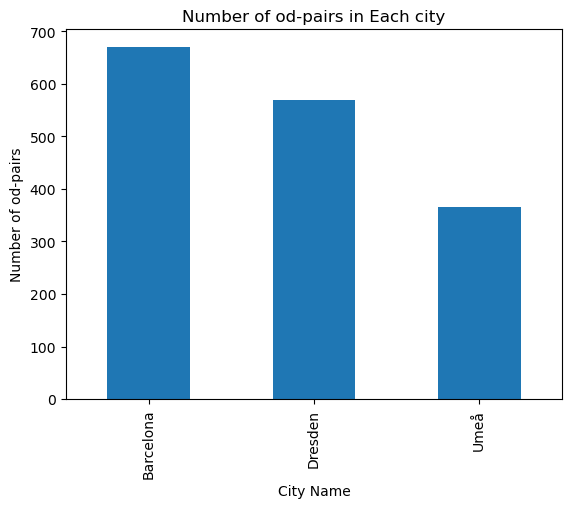

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

od_pair_data = pd.read_json("example/origin_od_pairs.json")
print(f"od-pairs before removing length outliers {len(od_pair_data)}")
od_pair_data = od_pair_data[od_pair_data['length_outliers'] == False]
print(f"od-pairs after removing length outliers {len(od_pair_data)}")

od_pair_data['closest_strongest_lag'] = abs(od_pair_data['closest_strongest_lag'])

od_pair_data = od_pair_data.sort_values(by="closest_strongest_lag", ascending=True)


city_counts = od_pair_data['city_name'].value_counts()
city_counts.plot(kind='bar')
plt.xlabel('City Name')
plt.ylabel('Number of od-pairs')
plt.title('Number of od-pairs in Each city')
plt.show()